In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import glob

import dicom2nifti
from tciaclient.core import TCIAClient
import pydicom
import os
import torchio as tio
import monai
import nibabel as nib
import einops
from utils import write_example_dino_augs, MultiCropWrapper, TimeMIP
import torch.nn as nn

# import dicom2nifti.settings as settings

# settings.disable_validate_slice_increment()
# settings.disable_validate_slicecount()
import monai.transforms
from train_3d_dino import get_args_parser
from train_3d_dino import DataAugmentationDINO as DataAugmentationDINO3D
from main_dino import DataAugmentationDINO as DataAugmentationDINO2D
from torchvision.utils import make_grid
from vision_transformer import DINOHead

from cmmd import CMMDRandomTileDataset
from torchvision import models as torchvision_models

from ispy2 import ISPY2Dataset

/home/annawoodard/miniconda3/envs/maicara/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
parser = get_args_parser()
args = parser.parse_args("")

In [7]:
x = torch.ones(3, 4, 4)

In [8]:
x.shape, x.view(x.size(0), -1).shape

(torch.Size([3, 4, 4]), torch.Size([3, 16]))

In [11]:
x = x.reshape(x.size(0), -1)

In [12]:
x.shape

torch.Size([3, 16])

In [4]:
network_3d = monai.networks.nets.resnet.resnet50(
    spatial_dims=3, n_input_channels=1, num_classes=1000
)
embed_dim_3d = network_3d.fc.weight.shape[1]
network_3d = MultiCropWrapper(
    network_3d,
    DINOHead(
        embed_dim_3d,
        args.out_dim,
        use_bn=args.use_bn_in_head,
        norm_last_layer=args.norm_last_layer,
    ),
)
network_3d = network_3d.cuda()

In [5]:
network_2d = torchvision_models.__dict__["resnet50"]()
network_2d.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
embed_dim_2d = network_2d.fc.weight.shape[1]
network_2d = MultiCropWrapper(
    network_2d,
    DINOHead(
        embed_dim_2d,
        args.out_dim,
        use_bn=args.use_bn_in_head,
        norm_last_layer=args.norm_last_layer,
    ),
)
network_2d = network_2d.cuda()

In [6]:
transform_2d = DataAugmentationDINO2D(
    global_crops_scale=(0.5, 1.0),
    local_crops_scale=(0.1, 0.5),
    local_crops_number=8,
    local_crops_size=96,
)

dataset_2d = CMMDRandomTileDataset(transform=transform_2d, tile_size=224)

dataloader_2d = torch.utils.data.DataLoader(
    dataset_2d,
    batch_size=3,
    num_workers=0,
)

2022-08-27 15:21:34,116 - 
train + validation dataset summary *************
          malignant                    benign
_______________________  _______________________
  views    unique women    views    unique women
-------  --------------  -------  --------------
   2632            1310     2958            1230



/home/annawoodard/miniconda3/envs/maicara/lib/python3.10/site-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
image_level_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys="image"),
        monai.transforms.EnsureChannelFirstd(keys="image"),
        TimeMIP(keys="image"),  # TODO take last volume
        monai.transforms.ScaleIntensityd(
            keys="image",
        ),
    ]
)
dataset = ISPY2Dataset(
    transform=image_level_transform,
    prescale=0.1,
    debug=args.debug,
    # metadata=fit_metadata,
    include_series=args.include_series,
    require_series=args.require_series,
    # timepoints=None,
)
# tile-level transforms
transform = DataAugmentationDINO3D(
    args.global_crops_scale,
    args.global_crops_size,
    args.local_crops_scale,
    args.local_crops_number,
    args.local_crops_size,
)
crop_sampler = monai.transforms.RandSpatialCropSamplesd(
    keys="image",
    roi_size=(
        args.global_crops_size,
        args.global_crops_size,
        args.global_crops_size,
    ),
    num_samples=args.tiles_per_image,
    random_center=True,
    random_size=False,
)
patch_dataset = monai.data.PatchDataset(
    data=dataset,
    patch_func=crop_sampler,
    samples_per_image=args.tiles_per_image,
    transform=transform,
)
dataloader_3d = torch.utils.data.DataLoader(
    patch_dataset,
    batch_size=3,
    num_workers=0,
)

removing 0 series with missing nifti files
2022-08-27 15:21:34,668 - 
train + validation dataset summary *************************************
                              pCR                              non-pCR
___________________________________  ___________________________________
  series    studies    unique women    series    studies    unique women
--------  ---------  --------------  --------  ---------  --------------
      63         63              53       132        132             114



In [8]:
for first_2d in dataloader_2d:
    break
for first_3d in dataloader_3d:
    break

/home/annawoodard/MONAI/monai/networks/layers/simplelayers.py:366: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:4158.)
  return torch.lstsq(y, a).solution.squeeze()


In [9]:
first_2d = [x.cuda("cuda:0") for x in first_2d]
first_3d = [x.cuda("cuda:0") for x in first_3d]

In [10]:
[x.shape for x in first_2d], [x.shape for x in first_3d]

([torch.Size([3, 1, 224, 224]),
  torch.Size([3, 1, 224, 224]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96]),
  torch.Size([3, 1, 96, 96])],
 [(3, 1, 96, 96, 96),
  (3, 1, 96, 96, 96),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64),
  (3, 1, 64, 64, 64)])

In [11]:
output_3d = network_3d(first_3d)

end idx, out shape tensor(2) (6, 2048)
end idx, out shape tensor(10) (24, 2048)
finished loop output shape is  (30, 2048)
HEAD!!!!! 
DINOHead(
  (mlp): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=2048, out_features=256, bias=True)
  )
  (last_layer): Linear(in_features=256, out_features=65536, bias=False)
)
got result  (30, 65536)
HEAD!!!!! 
DINOHead(
  (mlp): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=2048, out_features=256, bias=True)
  )
  (last_layer): Linear(in_features=256, out_features=65536, bias=False)
)


In [12]:
network_3d(torch.rand(1, 1, 96, 96, 96).cuda())

end idx, out shape tensor(1) torch.Size([1, 2048])


tensor([[-0.0542, -0.0584,  0.0492,  ..., -0.0368,  0.0621, -0.0328]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [41]:
embed_dim_2d, output_2d.shape

(2048, torch.Size([30, 65536]))

In [23]:
two_dim_network(two_dim_data)

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 4, 224, 224] to have 1 channels, but got 4 channels instead

In [3]:
def make_mip(image):
    shape = image.shape
    mip = torch.zeros(image.shape[1:3])
    for i in range(shape[1]):
        for j in range(shape[2]):
            mip[i, j] = torch.max(image[:, i, j, :])
    return mip

In [4]:
network = monai.networks.nets.UNETR(1, 1, 64, spatial_dims=3)

In [5]:
network = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1, out_channels=256
)

In [78]:
network = monai.networks.nets.resnet.resnet50(
    spatial_dims=3, n_input_channels=1, num_classes=256
)

In [80]:
foo = torch.rand((96, 96, 96)).unsqueeze(0).unsqueeze(0)
output = network(foo)

In [81]:
output.shape

torch.Size([1, 256])

In [14]:
parser = get_args_parser()
args = parser.parse_args("")

In [7]:
image_level_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=args.include_series),
        monai.transforms.EnsureChannelFirstd(keys=args.include_series),
        monai.transforms.ScaleIntensityd(
            keys=args.include_series,
        ),
    ]
)

In [8]:
dataset = ISPY2Dataset(
    transform=image_level_transform,
    prescale=args.prescale,
    debug=args.debug,
    include_series=args.include_series,
    # require_series=None,
    # timepoints=None,
    # cache_num=24,
    # cache_rate=1.0,
    # num_workers=4,
)

removing 0 series with missing nifti files
2022-08-25 11:57:23,788 - 
train + validation dataset summary *************************************
                              pCR                              non-pCR
___________________________________  ___________________________________
  series    studies    unique women    series    studies    unique women
--------  ---------  --------------  --------  ---------  --------------
     686        686             188      1387       1387             386



In [22]:
image = torch.Tensor(
    nib.load(dataset[0]["unilateral_dce_meta_dict"]["filename_or_obj"]).get_fdata()
)
image.shape

torch.Size([256, 256, 66, 7])

In [23]:
image = torch.Tensor(
    nib.load(dataset[1]["unilateral_dce_meta_dict"]["filename_or_obj"]).get_fdata()
)
image.shape

torch.Size([256, 256, 80, 8])

In [35]:
f = pydicom.dcmread(
    "/net/projects/cdac/annawoodard/ispy2/dicom/535569/1.3.6.1.4.1.14519.5.2.1.89300665660283291348724340435206843021/1.3.6.1.4.1.14519.5.2.1.136453698222548890623914293807900476182/99-d1ea442cdef1ba3d4b01d553b8a31ebd.dcm"
)

In [43]:
f.InstanceNumber

'183'

In [49]:
dicom2nifti.dicom_series_to_nifti(
    "/net/projects/cdac/annawoodard/ispy2/dicom/535569/1.3.6.1.4.1.14519.5.2.1.89300665660283291348724340435206843021/1.3.6.1.4.1.14519.5.2.1.136453698222548890623914293807900476182/",
    "foo.nii.gz",
)

2022-08-25 13:24:29,218 - Found manufacturer: GE
2022-08-25 13:24:29,533 - Reading and sorting dicom files
len of dicoms  462
2022-08-25 13:24:29,575 - Found sequence type: 4D
2022-08-25 13:24:29,576 - Creating data block
2022-08-25 13:24:29,577 - Creating block 1 of 7
2022-08-25 13:24:29,585 - Creating block 2 of 7
2022-08-25 13:24:29,594 - Creating block 3 of 7
2022-08-25 13:24:29,602 - Creating block 4 of 7
2022-08-25 13:24:29,610 - Creating block 5 of 7
2022-08-25 13:24:29,618 - Creating block 6 of 7
2022-08-25 13:24:29,627 - Creating block 7 of 7
2022-08-25 13:24:29,817 - Creating affine
2022-08-25 13:24:29,818 - Creating nifti
2022-08-25 13:24:29,820 - Saving nifti to disk foo.nii.gz


{'NII_FILE': 'foo.nii.gz',
 'NII': <nibabel.nifti1.Nifti1Image at 0x7f2bd07409d0>}

In [51]:
image.shape

torch.Size([256, 256, 80, 8])

In [38]:
f.pixel_array.shape

(256, 256)

In [50]:
f.NumberOfTemporalPositions

'6'

In [12]:

dataset[0]["unilateral_dce"].shape

(7, 256, 256, 66)

In [34]:
dataset[0]["unilateral_dce_meta_dict"]["filename_or_obj"]

'/net/projects/cdac/annawoodard/ispy2/nifti/535569/1.3.6.1.4.1.14519.5.2.1.89300665660283291348724340435206843021/1.3.6.1.4.1.14519.5.2.1.136453698222548890623914293807900476182.nii.gz'

In [31]:
image = torch.Tensor(
    nib.load(dataset[0]["unilateral_dce_meta_dict"]["filename_or_obj"]).get_fdata()
)

In [32]:
image.shape

torch.Size([256, 256, 80, 8])

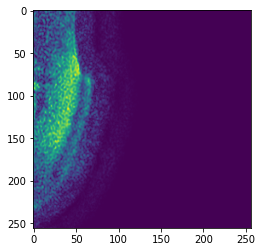

In [46]:
plt.imshow(image[:, :, 1, 7])

In [48]:
image[:, :, :, 7].shape

torch.Size([256, 256, 80])

In [48]:
load_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=args.include_series),
        monai.transforms.EnsureChannelFirstd(keys=args.include_series),
    ]
)
image = load_transform(foo)

/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.5664 0.5664 2.     1.    ] to [  0.56639999   0.56639999   2.         173.03312863]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


In [41]:
foo = {"unilateral_dce": dataset[0]["unilateral_dce_meta_dict"]["filename_or_obj"]}

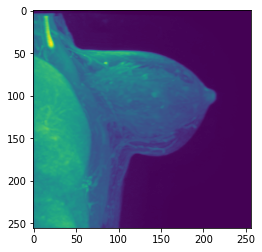

In [151]:
transformed_foo = image_level_transform(foo)
plt.imshow(make_mip(transformed_foo["unilateral_dce"]))

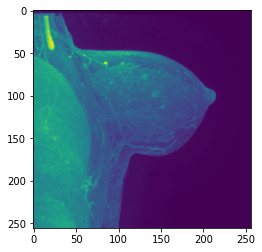

In [49]:
plt.imshow(make_mip(image["unilateral_dce"]))

In [14]:
dataset[0]["unilateral_dce_meta_dict"]["filename_or_obj"]

'/net/projects/cdac/annawoodard/ispy2/nifti/194024/1.3.6.1.4.1.14519.5.2.1.136438301631533568520619727075083245202/1.3.6.1.4.1.14519.5.2.1.75399329843664785087457711688705313384.nii.gz'

In [52]:
dataset[0]["unilateral_dce"].shape

(7, 256, 256, 66)

In [92]:
from vision_transformer import DINOHead

In [ ]:
head =         DINOHead(
            192,
            .out_dim,
            use_bn=args.use_bn_in_head,
            norm_last_layer=args.norm_last_layer,
        )

In [53]:
def three_dim_mip(image):
    shape = image.shape
    mip = torch.zeros(image.shape[1:])
    for i in range(shape[1]):
        for j in range(shape[2]):
            for k in range(shape[3]):
                mip[i, j, k] = torch.max(image[:, i, j, k])
    return mip

In [62]:
torch.amax(dataset[0]["unilateral_dce"], 0).shape

(256, 256, 66)

In [71]:
torch.amax(dataset[0]["unilateral_dce"], 0).unsqueeze(0).shape

(1, 256, 256, 66)

In [54]:
mip = three_dim_mip(dataset[0]["unilateral_dce"])

In [55]:
mip.shape

torch.Size([256, 256, 66])

In [58]:
mip.unsqueeze(0).shape

torch.Size([1, 256, 256, 66])

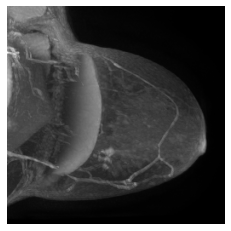

In [91]:
plt.imshow(make_mip(mip.unsqueeze(0)), cmap="gray")
plt.savefig("unilateral.pdf")

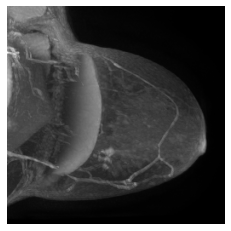

In [90]:
plt.imshow(make_mip(dataset[0]["unilateral_dce"]), cmap="gray")

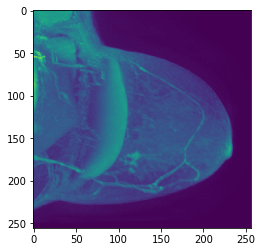

In [63]:
plt.imshow(make_mip(torch.amax(dataset[0]["unilateral_dce"], 0).unsqueeze(0)))

In [82]:
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
}
plt.rcParams.update(rc)

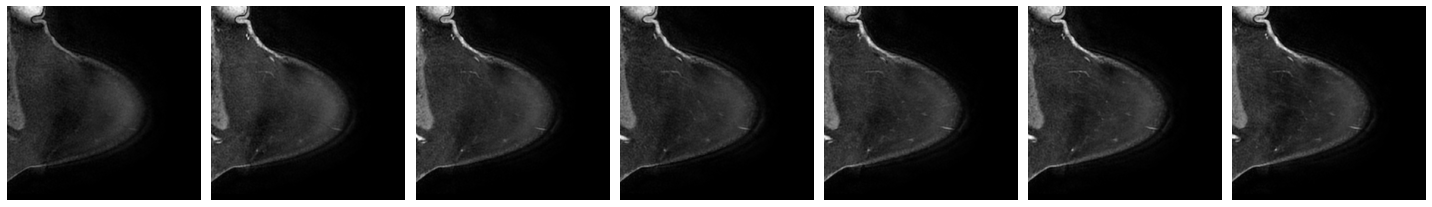

In [86]:
c, h, w, d = dataset[0]["unilateral_dce"].shape
fig, axes = plt.subplots(1, 7, figsize=(20, 10))
for i in range(c):
    axes[i].imshow(dataset[0]["unilateral_dce"][i, :, :, 50], cmap="gray")
fig.tight_layout()
plt.savefig("volumes.pdf")
plt.savefig("volumes.png")

In [87]:
dataset[0]["unilateral_dce"].shape

(7, 256, 256, 66)

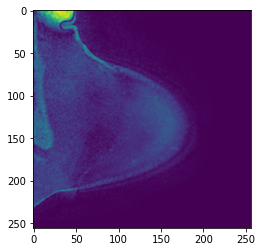

In [66]:
plt.imshow(dataset[0]["unilateral_dce"][0, :, :, 50])

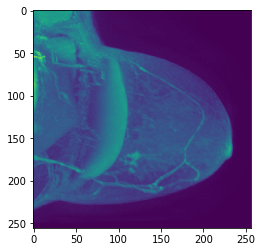

In [60]:
plt.imshow(make_mip(dataset[0]["unilateral_dce"]))

In [191]:
transform = DataAugmentationDINO(
    args.include_series,
    args.global_crops_scale,
    args.global_crops_size,
    args.local_crops_scale,
    args.local_crops_number,
    args.local_crops_size,
)
crop_sampler = monai.transforms.RandSpatialCropSamplesd(
    keys=args.include_series,
    roi_size=(
        args.global_crops_size,
        args.global_crops_size,
        args.global_crops_size,
    ),
    num_samples=args.tiles_per_image,
    random_center=True,
    random_size=False,
)
patch_dataset = monai.data.PatchDataset(
    data=dataset,
    patch_func=crop_sampler,
    samples_per_image=args.tiles_per_image,
    transform=transform,
)

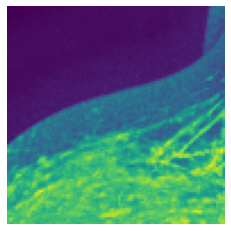

In [192]:
plt.imshow(make_mip(patch_dataset[0][0]))

In [195]:
patch_dataset[10][0].shape

(7, 96, 96, 96)

In [204]:
patch_dataset[10][0][0, :, :, 1].shape

(96, 96)

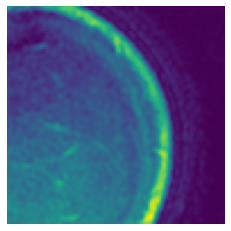

In [208]:
plt.imshow(patch_dataset[10][0][0, :, :, 1])

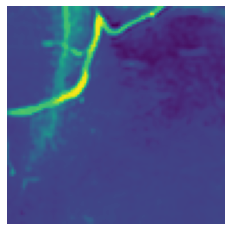

In [209]:
plt.imshow(patch_dataset[10][0][1, :, :, 1])

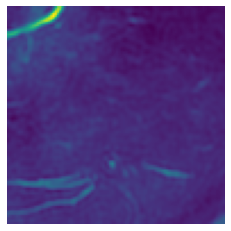

In [211]:
plt.imshow(patch_dataset[10][0][2, :, :, 1])

making mips...


2it [00:06,  3.50s/it]
2it [00:00, 191.18it/s]


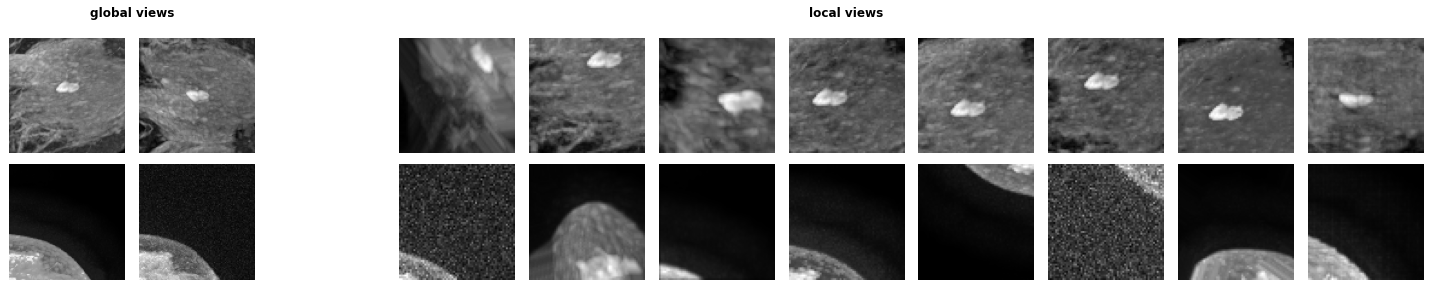

In [190]:
write_example_dino_augs(
    patch_dataset,
    ".",
    num_examples=2,
    local_crops_number=8,
    three_dim=True,
    series="unilateral_dce",
)

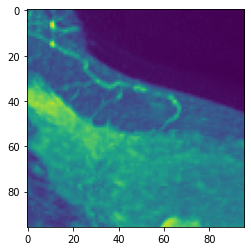

In [83]:
transformed_foo = patch_level_transform(patch)
plt.imshow(make_mip(transformed_foo["unilateral_dce"]))

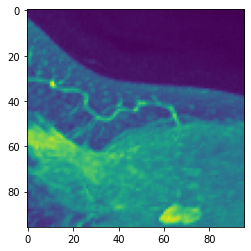

In [44]:
plt.imshow(make_mip(patch["unilateral_dce"]))

In [89]:
len(patch_dataset[0])

10

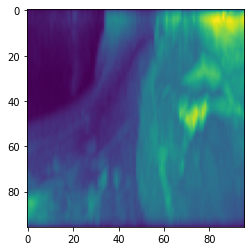

In [91]:
plt.imshow(make_mip(patch_dataset[0][0]["unilateral_dce"]))

In [17]:
patch_dataset[0]["unilateral_dce"].shape

(6, 96, 96, 96)

In [60]:
image = torch.Tensor(nib.load(no_transform_ds[0]["unilateral_dce"]).get_fdata())

In [61]:
image.shape

torch.Size([256, 256, 64, 9])

In [62]:
image = torch.einsum("hwzc->chwz", image)

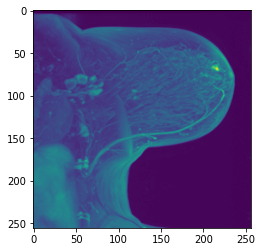

In [65]:
plt.imshow(make_mip(image))

In [96]:
global_crops_size = 92
crop = monai.transforms.RandSpatialCropSamples(
    roi_size=(global_crops_size, global_crops_size, global_crops_size),
    random_size=False,
    num_samples=1,
)

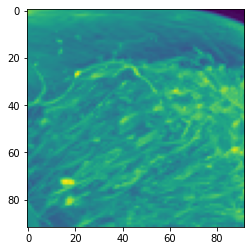

In [98]:
plt.imshow(make_mip(crop(image)[0]))

In [100]:
num_examples = 2
patch_lists = []
for i, entry in enumerate(dataset):
    patch_lists.append(entry)
    if i == num_examples:
        break

/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.7813 0.7813 1.2    1.    ] to [  0.78130001   0.78130001   1.20000005 107.15477759]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.84134614 0.84134614 2.5        1.        ] to [  0.84134614   0.84134614   2.5        119.99959672]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.84134614 0.84134614 2.5        1.        ] to [  0.84134614   0.84134614   2.5        108.6696129 ]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


In [101]:
patches = patch_lists[0]

In [102]:
len(patches)

4

In [103]:
global_views = [patches[0]["unilateral_dce"], patches[1][0]["unilateral_dce"]]

In [104]:
[x.shape for x in global_views]

[(6, 256, 256, 134), (6, 96, 96, 96)]

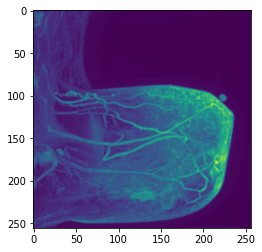

In [105]:
plt.imshow(make_mip(global_views[0]))

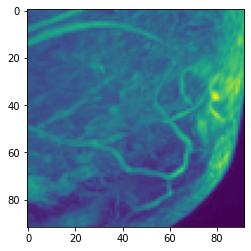

In [106]:
plt.imshow(make_mip(crop(global_views[0])[0]))

In [108]:
image_level_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=args.include_series),
        monai.transforms.EnsureChannelFirstd(keys=args.include_series),
        monai.transforms.Spacingd(
            keys=args.include_series, pixdim=(2.0, 2.0, 2.0), mode=("bilinear")
        ),
        monai.transforms.ScaleIntensityd(
            keys=args.include_series,
        ),
        monai.transforms.HistogramNormalized(keys=args.include_series, min=0, max=1),
        # monai.transforms.CropForegroundd(
        #     keys=include_series, source_key=include_series[0]
        # ),
        # monai.transforms.SpatialPadd(
        #     keys=include_series, spatial_size=(tile_size, tile_size, tile_size)
        # ),
        monai.transforms.OneOf(
            transforms=[
                monai.transforms.RandGaussianNoised(keys=args.include_series, prob=0.5),
                monai.transforms.RandBiasFieldd(keys=args.include_series),
                monai.transforms.RandKSpaceSpikeNoised(
                    keys=args.include_series, intensity_range=(10, 13)
                ),
            ]
        ),
        monai.transforms.OneOf(
            transforms=[
                monai.transforms.RandAdjustContrastd(keys=args.include_series),
                monai.transforms.RandHistogramShiftd(keys=args.include_series),
                monai.transforms.RandGaussianSmoothd(keys=args.include_series),
            ],
        ),
    ]
)
dataset = ISPY2Dataset(
    transform=image_level_transform,
    prescale=args.prescale,
    debug=args.debug,
    include_series=args.include_series,
    # require_series=None,
    # timepoints=None,
    # cache_num=24,
    # cache_rate=1.0,
    # num_workers=4,
)

removing 0 series with missing nifti files
2022-08-23 19:44:58,731 - 
train + validation dataset summary *************************************
                              pCR                              non-pCR
___________________________________  ___________________________________
  series    studies    unique women    series    studies    unique women
--------  ---------  --------------  --------  ---------  --------------
     686        686             188      1387       1387             386



Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.625 0.625 2.4   1.   ] to [  0.625        0.625        2.4000001  173.67479881]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.7031 0.7031 1.2    1.    ] to [  0.70310003   0.70310003   1.20000005 237.70217084]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.5469 0.5469 2.4    1.    ] to [  0.54689997   0.54689997   2.4000001  178.24184269]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/home/annawoodard/MONAI/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [0.5859 0.5859 2.     1.    ] to [  0.58590001   0.58590001   2.         189.3403546 ]
  warnings.warn(f"Modifying image pixdim

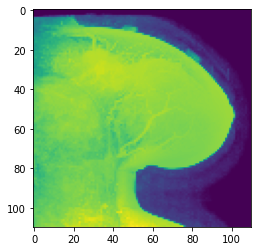

In [112]:
plt.imshow(make_mip(dataset[0]["unilateral_dce"]))

In [107]:
crop(global_views[0])[0].shape

(6, 92, 92, 92)

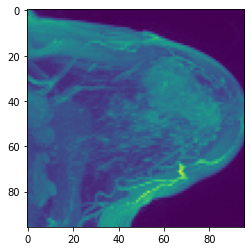

In [94]:
plt.imshow(make_mip(global_views[1]))

In [32]:
global_views

[tensor([[[[ 0.2602,  0.2480,  0.1964,  ...,  0.2494,  0.0784,  0.2640],
           [ 0.1542,  0.5783,  0.4077,  ...,  0.2104,  0.0809,  0.3023],
           [ 0.1496,  0.2051,  0.2947,  ...,  0.1288,  0.1191,  0.1595],
           ...,
           [-0.0175, -0.0109, -0.0208,  ..., -0.0231, -0.0243, -0.0064],
           [-0.0347, -0.0282, -0.0225,  ..., -0.0287, -0.0276, -0.0276],
           [-0.0198, -0.0242, -0.0126,  ..., -0.0163, -0.0308, -0.0241]],
 
          [[ 0.2465,  0.2430,  0.3297,  ...,  0.1931,  0.1496,  0.0694],
           [ 0.2744,  0.2880,  0.4432,  ...,  0.1637,  0.0768,  0.0841],
           [ 0.2610,  0.2148,  0.2950,  ...,  0.2128,  0.2426,  0.2725],
           ...,
           [-0.0125, -0.0223, -0.0198,  ..., -0.0183, -0.0319, -0.0348],
           [-0.0315, -0.0332, -0.0393,  ..., -0.0311, -0.0106, -0.0301],
           [-0.0114, -0.0137, -0.0365,  ..., -0.0253, -0.0318, -0.0369]],
 
          [[ 0.0835,  0.3402,  0.3043,  ...,  0.0303,  0.1368,  0.1433],
           [ 

In [12]:
global_views = make_grid([patches[0][0], nrow=2)[
    0,
    :,
]

TypeError: tensor or list of tensors expected, got a list containing <class 'list'>

In [ ]:
# image = torch.rand(64, 64, 64)
# image = torch.rand(96, 96, 96)
image = torch.rand(32, 32, 32)

In [ ]:
image.unsqueeze(0).unsqueeze(0).shape

In [ ]:
output = network(image.unsqueeze(0).unsqueeze(0))
output.shape

In [ ]:
ds[0].pcR

In [ ]:
series = pd.read_csv(
    "/net/projects/cdac/annawoodard/ispy2/nifti/per_series_metadata.csv"
)

In [ ]:
series.StudyInstanceUID.nunique()

In [ ]:
subject = tio.Subject(
    foo=1,
    bar=tio.ScalarImage(
        "/net/projects/cdac/annawoodard/ispy2/nifti/111038/1.3.6.1.4.1.14519.5.2.1.315644730345418690449328426879972074536/1.3.6.1.4.1.14519.5.2.1.275568364773316238145583867300273394204.nii.gz"
    ),
    baz=tio.ScalarImage(
        "/net/projects/cdac/annawoodard/ispy2/nifti/105286/1.3.6.1.4.1.14519.5.2.1.313874426419002638153291825928940598509/1.3.6.1.4.1.14519.5.2.1.229474878840607634465334260137285969422.nii.gz"
    ),
)

In [ ]:
subject.get_images()

In [ ]:
series = series[~pd.isnull(series.SeriesDescription)]

In [ ]:
a = set(["a", "b"])
b = set(["a", "b", "c"])
c = set(["c"])

In [ ]:
a & b

In [ ]:
series[series.StudyInstanceUID == series.StudyInstanceUID.iloc[0]].SeriesDescription

In [ ]:
series[
    series.SeriesDescription.str.contains(
        "ISPY2: DynaVIEWS 90s Post|ISPY2: VOLSER: uni-lateral cropped: original DCE"
    )
]

In [ ]:
series[series.ClinicalTrialTimePointID == "T3"].StudyInstanceUID.nunique()

In [ ]:
len(patient_dirs)

In [ ]:
client = TCIAClient()

In [ ]:
series = client.get_series(collection="ISPY2", modality="MR")

In [ ]:
series = pd.DataFrame(series)

In [ ]:
series.head()

In [ ]:
series.groupby("PatientID")["StudyInstanceUID"].nunique().value_counts()

In [ ]:
series["num_exams"] = series.groupby("PatientID")["StudyInstanceUID"].transform(
    "nunique"
)

In [ ]:
series.num_exams.value_counts()

In [ ]:
series[series.num_exams == 4].StudyInstanceUID.nunique(), series[
    series.num_exams == 4
].PatientID.nunique()

In [ ]:
series[series.num_exams == 4].SeriesDescription.value_counts()

In [ ]:
series = pd.read_csv(
    "/net/projects/cdac/annawoodard/ispy2/nifti/per_series_metadata.csv"
)

In [ ]:
series

In [ ]:
len(series.to_dict("record"))

In [ ]:
series.head()

In [ ]:
series.PatientID.nunique()

In [ ]:
719 * 

In [ ]:
pd.set_option("display.max_rows", 500)
series.SeriesDescription.value_counts()

In [ ]:
f = pydicom.dcmread(
    "/net/projects/cdac/annawoodard/ispy2/dicom/ISPY2-876511/1.3.6.1.4.1.14519.5.2.1.102039608389526714321512911577543318112/1.3.6.1.4.1.14519.5.2.1.264529442118933018769492574134988947852/52-e32ca8e6e8608ab0ebee13fbd1b9aefa.dcm"
)

In [ ]:
dir(f)

In [ ]:
from retry import retry

In [ ]:
os.path.isdir(
    "/net/projects/cdac/annawoodard/ispy2/dicom/ISPY2-640463/1.3.6.1.4.1.14519.5.2.1.189196263140751942023815775792952326950/1.3.6.1.4.1.14519.5.2.1.277189336828774809052497763507763283260.partial"
)

In [ ]:
client.get_image(
    seriesInstanceUid="1.3.6.1.4.1.14519.5.2.1.41837773012368583339427101877970890440",
    downloadPath=".",
    zipFileName="data.zip",
)

In [ ]:
dicom2nifti.dicom_series_to_nifti(
    "/home/annawoodard/dino/foo",
    "/home/annawoodard/dino/foo.nii.gz",
    reorient_nifti=True,
)

In [ ]:
clinical_data = pd.read_excel(
    "/net/projects/cdac/annawoodard/ispy2/dicom/clinical_data.xlsx"
)

In [ ]:
clinical_data.head()

In [ ]:
series_metadata = pd.read_csv(
    "/net/projects/cdac/annawoodard/ispy2/per_series_metadata.csv"
)

In [ ]:
series_metadata[series_metadata.PatientID == "ISPY2-756412"].StudyInstanceUID.nunique()

In [ ]:
series_metadata.PatientID = series_metadata.PatientID.str.lstrip("ISPY2-").astype(int)

In [ ]:
series_metadata.PatientID

In [ ]:
clinical_data.pCR.value_counts()

In [ ]:
clinical_data = clinical_data.rename(columns={"Patient_ID": "PatientID"})

In [ ]:
metadata = series_metadata.join(clinical_data.set_index("PatientID"), on="PatientID")

In [ ]:
metadata.pCR.value_counts()

In [ ]:
clinical_data.head()

In [ ]:
clinical_data.Patient_ID

In [ ]:
from tciaclient.core import TCIAClient

In [ ]:
client = TCIAClient()
series = client.get_series(collection="ISPY2", modality="MR")

In [ ]:
series[0]

In [ ]:
ds = CMMDRandomTileDataset()

In [ ]:
ds[0]

In [ ]:
cropped_image = crop(F.to_tensor(ds[0]))

In [ ]:
plt.imshow(cropped_image.squeeze())

In [ ]:
cropped_image.shape

In [ ]:
image = F.to_tensor(ds[0])

In [ ]:
image.shape

In [ ]:
plt.imshow(crop(image).squeeze().squeeze())

In [ ]:
plt.imshow(image.squeeze())

In [ ]:
plt.imshow(
    image[
        :,
        :,
        1000:1500,
    ].squeeze()
)

In [ ]:
image[:, 1000:1500].squeeze().shape

In [ ]:
image[
    :,
    :,
    # 1000:1500,
    :500,
].squeeze().shape